<a href="https://colab.research.google.com/github/robertobruzzese/article-lab/blob/main/Progetto_fiverr_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import os

import torch # PyTorch package
import torchvision # load datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
# torchvision for pre-trained models
from torchvision import models

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torchvision.transforms as transforms #  augment data
import torch.nn as nn #  building  neural neteorks
import torch.nn.functional as F #  convolution functions like Relu
import torch.optim as optim # optimzer 
from torchsummary import summary

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import warnings #Ability to create custom warnings, like warnings.warn("deprecated", DeprecationWarning)
import itertools #Needed for Confusion Matrix

In [ ]:
def PlotCategoricalMetrics(Y_Hat, Targets, ClassNames, Normalise, figsize = None):
    """Plots the Confusion matrix given the class index (0 to K-1), and the Actual values."""
    PrevFigSize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = figsize if figsize is not None else PrevFigSize
    
    sk_conf_matrx = confusion_matrix(Targets, Y_Hat)
    plot_confusion_matrix(sk_conf_matrx, ClassNames, Normalise = Normalise)
    
    plt.rcParams['figure.figsize'] = PrevFigSize

In [ ]:
def plot_confusion_matrix(sk_conf_matrx, Classes, Normalise = False, Title = 'Confusion matrix', Colourmap = plt.cm.Blues):
    """Plot the Confusion Matrix object returned by sklearn's confusion_matrix() and Normalise it if Normalise==True."""
    plt.grid(False)
    if Normalise:
        print('Confusion matrix')
        print(sk_conf_matrx)
        sk_conf_matrx = sk_conf_matrx.astype('float') / sk_conf_matrx.sum(axis = 1)[:, np.newaxis]
        plt.imshow(sk_conf_matrx, interpolation = 'nearest', cmap = Colourmap)
        plt.clim(0.0, 1.0)
    else:
        plt.imshow(sk_conf_matrx, interpolation = 'nearest', cmap = Colourmap)
    plt.title(Title)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.colorbar()
    tick_marks = np.arange(len(Classes))
    plt.xticks(tick_marks, Classes, rotation = 45)
    plt.yticks(tick_marks, Classes)
    
    fmt = '.2f' if Normalise else 'd'
    thresh = sk_conf_matrx.max() / 2.
    for i, j in itertools.product(range(sk_conf_matrx.shape[0]), range(sk_conf_matrx.shape[1])):
        plt.text(j, i, format(sk_conf_matrx[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if sk_conf_matrx[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
train_root='./dataset_9010/dataset_9010/malimg_dataset/train'
val_root='./validation_ds_update_924/validation_ds_update_924/malimg_dataset/validation'

In [ ]:
data_aug_transforms = [
     transforms.RandomHorizontalFlip(), 
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomAffine(degrees=75),
     transforms.RandomAffine(degrees=0,translate=(0.5,0.5)),
     transforms.RandomAffine(degrees=0,scale=(0.7,0.7))
 ]

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/AML_DATA/'

/content/drive/.shortcut-targets-by-id/1PHQ0lh7VNfUJjD9R69bWwquzSpqaGt3s/AML_DATA


In [ ]:
img_size=(64, 64)

data_transform=transforms.Compose(
   [ transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
   ])
# mean and std are calculated from the ImageNet images

orig_set = torchvision.datasets.ImageFolder(root=train_root , transform=data_transform )
val_= torchvision.datasets.ImageFolder(root=val_root )

n = len(orig_set)  # total number of examples

print(f'Number of original examples: {len(orig_set)}')
print(f'Number of Validation examples: {len(val_)}')

print("Number of classes in training set : \n", len(orig_set.classes))
print("The following classes are in training set : \n",orig_set.classes)

Number of original examples: 8404
Number of Validation examples: 924
Number of classes in training set : 
 25
The following classes are in training set : 
 ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root=train_root , transform=data_transform )
val_dataset = torchvision.datasets.ImageFolder(root=val_root , transform=data_transform)

print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of Validation examples: {len(val_dataset)}')

batch_size = 128
train_loader=DataLoader(train_dataset,batch_size=batch_size , shuffle=True )
val_loader=DataLoader(val_dataset,batch_size=batch_size ,shuffle=False)

Number of training examples: 8404
Number of Validation examples: 924


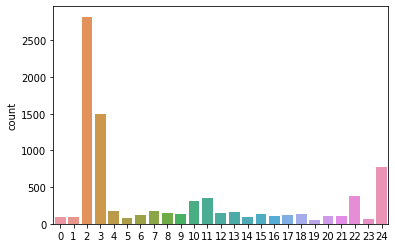

In [ ]:
import seaborn as sns
sns.countplot(x = train_dataset.targets)
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

input_size = 3
num_classes = 25
num_epochs = 6
batch_size = 128
learning_rate = 5e-4
learning_rate_decay = 0.98
reg = 0.20
num_training= 8404
num_validation = 924

# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
accuracy_val = []
train_acc_curve=[]

Using device: cuda


In [ ]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# loading the pretrained model vgg16
model = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# Freeze model vgg16 weights
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Add on classifier
# model.classifier[6] = Sequential(
#                       Linear(4096, 8192),
#                       Dropout(0.5),
#                       Linear(8192, 25)
#                       )
model.classifier[6] = Sequential(
                      Linear(4096, 25)
                      )
for param in model.classifier[6].parameters():
    param.requires_grad = True
#print(model.classifier.parameters) 
print(model)
# print(model.features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
criterion = nn.CrossEntropyLoss()

  2%|▏         | 1/66 [00:45<49:26, 45.63s/it]

 Epoch [1/6], Step [1/66], Loss: 3.3445


 76%|███████▌  | 50/66 [36:48<11:46, 44.16s/it]

 Epoch [1/6], Step [50/66], Loss: 0.7288


Epoch [1/6]. Train: Loss 0.0089, Acc 66.28 | Valid: Loss 0.0057, Acc 81.06



  2%|▏         | 1/66 [00:00<00:39,  1.64it/s]

 Epoch [2/6], Step [1/66], Loss: 0.6306


 76%|███████▌  | 50/66 [00:30<00:09,  1.66it/s]

 Epoch [2/6], Step [50/66], Loss: 0.7316


Epoch [2/6]. Train: Loss 0.0052, Acc 81.38 | Valid: Loss 0.0048, Acc 82.79



  2%|▏         | 1/66 [00:00<00:42,  1.53it/s]

 Epoch [3/6], Step [1/66], Loss: 0.6820


 76%|███████▌  | 50/66 [00:30<00:09,  1.71it/s]

 Epoch [3/6], Step [50/66], Loss: 0.7594


Epoch [3/6]. Train: Loss 0.0049, Acc 82.21 | Valid: Loss 0.0046, Acc 84.31



  2%|▏         | 1/66 [00:00<00:38,  1.67it/s]

 Epoch [4/6], Step [1/66], Loss: 0.6960


 76%|███████▌  | 50/66 [00:29<00:09,  1.64it/s]

 Epoch [4/6], Step [50/66], Loss: 0.6682


Epoch [4/6]. Train: Loss 0.0047, Acc 83.26 | Valid: Loss 0.0047, Acc 81.93



  2%|▏         | 1/66 [00:00<00:37,  1.75it/s]

 Epoch [5/6], Step [1/66], Loss: 0.3757


 76%|███████▌  | 50/66 [00:29<00:09,  1.64it/s]

 Epoch [5/6], Step [50/66], Loss: 0.5639


Epoch [5/6]. Train: Loss 0.0047, Acc 83.00 | Valid: Loss 0.0047, Acc 83.66



  2%|▏         | 1/66 [00:00<00:36,  1.79it/s]

 Epoch [6/6], Step [1/66], Loss: 0.4874


 76%|███████▌  | 50/66 [00:30<00:09,  1.69it/s]

 Epoch [6/6], Step [50/66], Loss: 0.7049


Epoch [6/6]. Train: Loss 0.0047, Acc 83.07 | Valid: Loss 0.0048, Acc 83.66



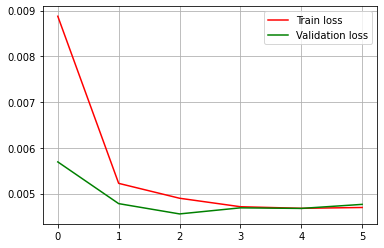

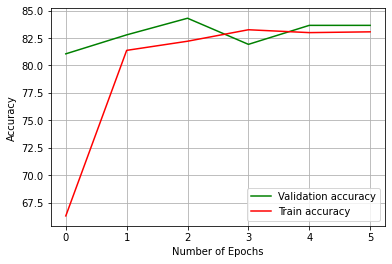

Confusion matrix
[[ 25   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0  23   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1   0   0]
 [  0   0 105   9   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0  38  62   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0  24   0   0   0   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  25]
 [  0   0   5   1   0   0  11   2   0   0   0   0   0   0   0   0   0   0
    2   0   0   3   1   0   0]
 [  0   0   1   0   0   0   1  22   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0  25   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 

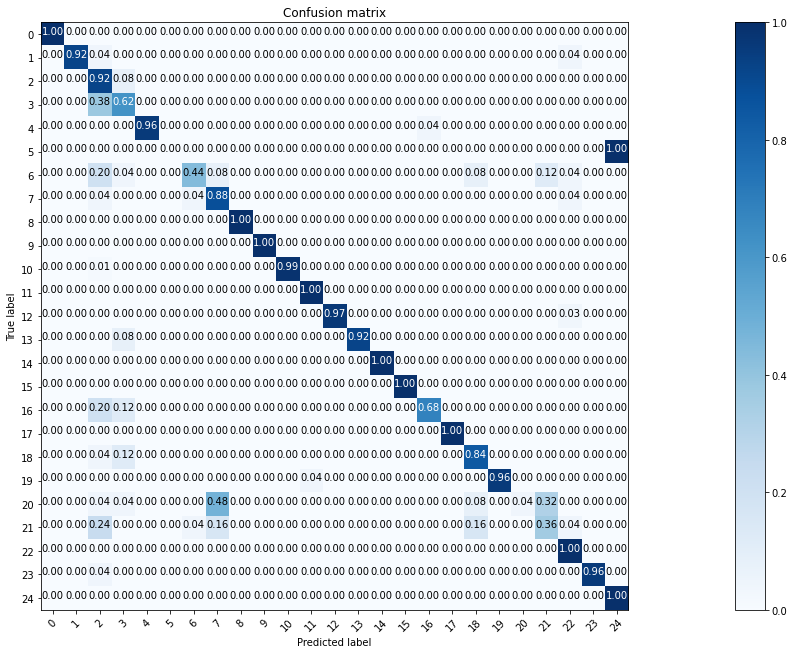

In [ ]:
PrintEveryN = 1
for epoch in range(num_epochs):
    correct = 0
    total = 0

    model.to(device)
    model.train()

    loss_iter = 0
    for i, (images, labels) in tqdm(enumerate(train_loader), total = len(train_loader), leave = False):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss_iter += loss.item()
        if i == 0 or (i+1) % 50 == 0:
            print (' Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
    loss_train.append(loss_iter/(len(train_loader)*batch_size))
    
    ###
    _train_acc = 100 * correct / total
    train_acc_curve.append(_train_acc)
    ###

    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    predictions = []
    targets = []
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in tqdm(val_loader, total = len(val_loader), leave = False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted.cpu().numpy())
            targets.append(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss_iter += loss.item()
        
        loss_val.append(loss_iter/(len(val_loader)*batch_size))

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)

    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)

    if epoch == 0 or (epoch+1) % PrintEveryN == 0 or (epoch+1) == num_epochs:
        print ('Epoch [{}/{}]. Train: Loss {:.4f}, Acc {:.2f} | Valid: Loss {:.4f}, Acc {:.2f}\n'.format(epoch+1, num_epochs, loss_train[-1], _train_acc, loss_val[-1], accuracy))

model.eval()

plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Validation loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(3)
plt.plot(accuracy_val, 'g', label='Validation accuracy')
plt.plot(train_acc_curve, 'r', label='Train accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#Viewing the overall Categorical metrics and Plotting the Confusion Matrix
PlotCategoricalMetrics(predictions, targets, range(25), Normalise = True, figsize = [30, 9])